经过 1000 次迭代，用时为: 0.364025354385376  最小值为: 0.03871043867671842 最优解为: [1.0389970849735117, 1.1091449257897874, 1.5329793198015642]
经过 1000 次迭代，用时为: 0.3370983600616455  最小值为: 0.04145129629158868 最优解为: [1.039044058562379, 1.1080263939440844, 1.5410761806316422]


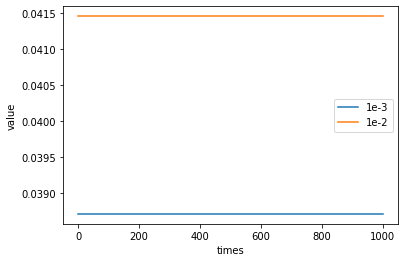

In [13]:
##外点法
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import time
from math import sqrt
import math
from numpy.linalg import norm
def f(x0,x1,x2):#最优化目标函数
    return (x0-1)**2+(x0-x1)**2+(x1-x2)**4
def h(x0,x1,x2):#等式约束
    x=np.array([x0,x1,x2])
    return (x[0]*(1+x[1]**2)+x[2]**4-4-3*sqrt(2))**2
def g1(x):#x1,x2,x3>-10的不等式约束
    gx=[]
    for i in range(3):
        gx.append(x[i]+10)
    return np.array(gx)
def g2(x):#x1,x2,x3<10的不等式约束
    gx=[]
    for i in range(3):
        gx.append(10-x[i])
    return np.array(gx)
def g_g1(x):#x1,x2,x3>-10的不等式约束的导数
    return np.array([1,1,1])
def g_g2(x):#x1,x2,x3<10的不等式约束的导数
    return np.array([-1,-1,-1])
def g_h(x):#等式约束的导数
    [x0,x1,x2]=symbols('x0:3')
    grad=[]
    for i in range(len(x)):#用sympy中的diff模块求导
        grad.append(np.float32((diff(h(x0,x1,x2),eval('x'+str(i))).subs({x0:x[0],x1:x[1],x2:x[2]}))))
    return np.array(grad)
def g_f(x):#目标函数的导数
    [x0,x1,x2]=symbols('x0:3')
    grad=[]
    for i in range(len(x)):#用sympy中的diff模块求导
        grad.append(np.float32((diff(f(x0,x1,x2),eval('x'+str(i))).subs({x0:x[0],x1:x[1],x2:x[2]}))))
    return np.array(grad)#目标函数和等式约束的导数+不等式约束的导数，他们之和为PE函数的导数
def update_r(x,ri1,ri2,rj):#拉格朗日算子的更新方法
    for i in range(3):
        ri1[i]=max(ri1[i]-miu*(x[i]+10),0)#不等式约束的更新方法
        ri2[i]=max(ri2[i]-miu*(10-x[i]),0)
    rj=rj-miu*h(x[0],x[1],x[2])#等式约束的更新方法
    return ri1,ri2,rj
def judge(x):#惩罚值的大小
    hx=h(x[0],x[1],x[2])
    gx=[]
    g1x=g1(x)
    g2x=g2(x)
    for i in range(3):
        gx.append(min(g1x[i],0))
        gx.append(min(g2x[i],0))
    gx=np.array(gx)
    return math.fabs(hx)+np.linalg.norm(gx)**2
def update_miu(x_now,x_pre,beta,miu):#判断惩罚值是否有足够的下降，若无，则增大惩罚参数miu
    pre=judge(x_pre)
    now=judge(x_now)
    if now/pre>beta:
        miu*=10
    return miu
def Lagrange(x):#拉格朗日函数
    x0,x1,x2=x[0],x[1],x[2]
    g_1=np.where(ri1-miu*g1(x)>0,ri1-miu*g1(x),0)
    g_2=np.where(ri2-miu*g2(x)>0,ri1-miu*g1(x),0)
    return f(x0,x1,x2)+1/(2*miu)*(norm(g_1)**2+norm(g_2)**2-norm(ri1)**2-norm(ri2)**2)-rj*h(x0,x1,x2)+0.5*miu*h(x0,x1,x2)**2

def g_Lag(x):#拉格朗日函数的导数
    g_1=np.where(ri1-miu*g1(x)>0,ri1-miu*g1(x),0)
    g_2=np.where(ri2-miu*g2(x)>0,ri1-miu*g1(x),0)
    return g_f(x)-g_1*g_g1(x)-g_2*g_g2(x)-(rj-miu*h(x[0],x[1],x[2]))*g_h(x)

def train(x,miu,ri1,ri2,rj):#采用最速下降法优化
    start=time.time()
    last_x=np.zeros(len(x))#xk-1。
    k=0
    d=np.zeros(len(x))
    to_plot=[]
    while judge(x)>eplison and k<1000:#终止条件：两点间距离小于0.001的时候停止
        while np.linalg.norm(x-last_x)>eplison or np.linalg.norm(last_x)==0:
            gk=g_Lag(x)
            d=-gk
            step = 2
            x0,x1,x2=x[0],x[1],x[2]
            
            while Lagrange(x+step*d) > Lagrange(x) +rho* step * np.dot(gk,d):#向d的方向下降，若
                                                            #步长不满足armijio准则，则令步长变为0.8倍
                step *= beta
            last_x=x
            x = x + step * d#更新x点
        to_plot.append(f(x0,x1,x2))
        miu=update_miu(x,last_x,0.6,miu)
        ri1,ri2,rj=update_r(x,ri1,ri2,rj)
        k+=1
    print('经过',k,'次迭代，用时为:',time.time()-start,' 最小值为:',f(x0,x1,x2),'最优解为:',[x0,x1,x2])
    return to_plot
x=[2,2,2]
miu=6
rho=0.0006
ri1,ri2,rj=np.array([1,1,1]),np.array([1,1,1]),1
g_Lag(x)
beta=0.4
eplison=1e-3
to_plot=train(x,miu,ri1,ri2,rj)
fig,ax=plt.subplots(1,1)
ax.plot(to_plot)
ax.set_xlabel('times')
ax.set_ylabel('value')
eplison=1e-2
to_plot=train(x,miu,ri1,ri2,rj)
ax.plot(to_plot)
ax.legend(['1e-3','1e-2'])



经过 1000 次迭代，用时为: 0.3639993667602539  最小值为: 0.03871043867671842 最优解为: [1.0389970849735117, 1.1091449257897874, 1.5329793198015642]
经过 1000 次迭代，用时为: 0.33411335945129395  最小值为: 0.04145129629158868 最优解为: [1.039044058562379, 1.1080263939440844, 1.5410761806316422]


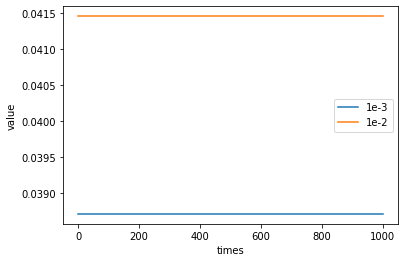

In [14]:
##拉格朗日乘数法
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import time
from math import sqrt
import math
from numpy.linalg import norm
def f(x0,x1,x2):#最优化目标函数
    return (x0-1)**2+(x0-x1)**2+(x1-x2)**4
def h(x0,x1,x2):#等式约束
    x=np.array([x0,x1,x2])
    return (x[0]*(1+x[1]**2)+x[2]**4-4-3*sqrt(2))**2
def g1(x):#x1,x2,x3>-10的不等式约束
    gx=[]
    for i in range(3):
        gx.append(x[i]+10)
    return np.array(gx)
def g2(x):#x1,x2,x3<10的不等式约束
    gx=[]
    for i in range(3):
        gx.append(10-x[i])
    return np.array(gx)
def g_g1(x):#x1,x2,x3>-10的不等式约束的导数
    return np.array([1,1,1])
def g_g2(x):#x1,x2,x3<10的不等式约束的导数
    return np.array([-1,-1,-1])
def g_h(x):#等式约束的导数
    [x0,x1,x2]=symbols('x0:3')
    grad=[]
    for i in range(len(x)):#用sympy中的diff模块求导
        grad.append(np.float32((diff(h(x0,x1,x2),eval('x'+str(i))).subs({x0:x[0],x1:x[1],x2:x[2]}))))
    return np.array(grad)
def g_f(x):#目标函数的导数
    [x0,x1,x2]=symbols('x0:3')
    grad=[]
    for i in range(len(x)):#用sympy中的diff模块求导
        grad.append(np.float32((diff(f(x0,x1,x2),eval('x'+str(i))).subs({x0:x[0],x1:x[1],x2:x[2]}))))
    return np.array(grad)#目标函数和等式约束的导数+不等式约束的导数，他们之和为PE函数的导数
def update_r(x,ri1,ri2,rj):#拉格朗日算子的更新方法
    for i in range(3):
        ri1[i]=max(ri1[i]-miu*(x[i]+10),0)#不等式约束的更新方法
        ri2[i]=max(ri2[i]-miu*(10-x[i]),0)
    rj=rj-miu*h(x[0],x[1],x[2])#等式约束的更新方法
    return ri1,ri2,rj
def judge(x):#惩罚值的大小
    hx=h(x[0],x[1],x[2])
    gx=[]
    g1x=g1(x)
    g2x=g2(x)
    for i in range(3):
        gx.append(min(g1x[i],0))
        gx.append(min(g2x[i],0))
    gx=np.array(gx)
    return math.fabs(hx)+np.linalg.norm(gx)**2
def update_miu(x_now,x_pre,beta,miu):#判断惩罚值是否有足够的下降，若无，则增大惩罚参数miu
    pre=judge(x_pre)
    now=judge(x_now)
    if now/pre>beta:
        miu*=10
    return miu
def Lagrange(x):#拉格朗日函数
    x0,x1,x2=x[0],x[1],x[2]
    g_1=np.where(ri1-miu*g1(x)>0,ri1-miu*g1(x),0)
    g_2=np.where(ri2-miu*g2(x)>0,ri1-miu*g1(x),0)
    return f(x0,x1,x2)+1/(2*miu)*(norm(g_1)**2+norm(g_2)**2-norm(ri1)**2-norm(ri2)**2)-rj*h(x0,x1,x2)+0.5*miu*h(x0,x1,x2)**2

def g_Lag(x):#拉格朗日函数的导数
    g_1=np.where(ri1-miu*g1(x)>0,ri1-miu*g1(x),0)
    g_2=np.where(ri2-miu*g2(x)>0,ri1-miu*g1(x),0)
    return g_f(x)-g_1*g_g1(x)-g_2*g_g2(x)-(rj-miu*h(x[0],x[1],x[2]))*g_h(x)

def train(x,miu,ri1,ri2,rj):#采用最速下降法优化
    start=time.time()
    last_x=np.zeros(len(x))#xk-1。
    k=0
    d=np.zeros(len(x))
    to_plot=[]
    while judge(x)>eplison and k<1000:#终止条件：两点间距离小于0.001的时候停止
        while np.linalg.norm(x-last_x)>eplison or np.linalg.norm(last_x)==0:
            gk=g_Lag(x)
            d=-gk
            step = 2
            x0,x1,x2=x[0],x[1],x[2]
            
            while Lagrange(x+step*d) > Lagrange(x) +rho* step * np.dot(gk,d):#向d的方向下降，若
                                                            #步长不满足armijio准则，则令步长变为0.8倍
                step *= beta
            last_x=x
            x = x + step * d#更新x点
        to_plot.append(f(x0,x1,x2))
        miu=update_miu(x,last_x,0.6,miu)
        ri1,ri2,rj=update_r(x,ri1,ri2,rj)
        k+=1
    print('经过',k,'次迭代，用时为:',time.time()-start,' 最小值为:',f(x0,x1,x2),'最优解为:',[x0,x1,x2])
    return to_plot
x=[2,2,2]
miu=6
rho=0.0006
ri1,ri2,rj=np.array([1,1,1]),np.array([1,1,1]),1
g_Lag(x)
beta=0.4
eplison=1e-3
to_plot=train(x,miu,ri1,ri2,rj)
fig,ax=plt.subplots(1,1)
ax.plot(to_plot)
ax.set_xlabel('times')
ax.set_ylabel('value')
eplison=1e-2
to_plot=train(x,miu,ri1,ri2,rj)
ax.plot(to_plot)
ax.legend(['1e-3','1e-2'])
